In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
from scipy.stats import mannwhitneyu
import datetime
import json
import pickle
from tqdm import tqdm
import warnings
import lightgbm as lgb
import math
import random
import pdb
import re
from collections import defaultdict

from sklearn.metrics import *
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

warnings.filterwarnings(action='ignore')




def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

def split_time(x):
    x = str(x)
    year = x[:4]
    month = x[4:6]
    day = x[6:8]
    hour = x[8:10]
    minute = x[10:12]
    second = x[12:14]
    return year, month, day, hour, minute, second

def make_time_cols(df_):
    years, months, days, hours, minutes, seconds, dates = [], [], [], [], [], [], []
    times = df_['time'].tolist()
    for i in range(len(times)):
        x = times[i]
        year, month, day, hour, minute, second = split_time(x)
        years.append(int(year))
        months.append(int(month))
        days.append(int(day))
        hours.append(int(hour))
        minutes.append(int(minute))
        seconds.append(int(second))
        dates.append(datetime.datetime.strptime(str(x), "%Y%m%d%H%M%S"))
    
    df_['year'] = years
    df_['month'] = months
    df_['day'] = days
    df_['hour']=hours
    df_['minute'] = minutes
    df_['second']= seconds
    df_['date'] = dates
    return df_


def add_time_cols(df_):
    df_ = make_time_cols(df_)
    df_['weeknum'] = df_['date'].apply(lambda x: x.weekday())
    df_['weekend'] = df_['weeknum'].apply(lambda x: 1 if x >=5 else 0)
    df_['md'] = df_['month'].apply(lambda x: str(x).zfill(2)) + df_['day'].apply(lambda x: str(x).zfill(2))
    return df_

In [2]:
default_path = os.getcwd()
data_path = os.path.join(default_path,'data')

In [10]:
def processing_train_test(data_path, option='train'):
    """
    raw file들에 data 객체를 넣어주고 quality의 경우 fwver값이 nan인 경우 수정함
    
    input
    ----------------------------
    data_path : data가 있는 path
    option : train or test
    """
    if option == 'train':
        err_name = 'train_err_data'
        qua_name = 'train_quality_data'
        prob_name = 'train_problem_data'
    elif option == 'test':
        err_name = 'test_err_data'
        qua_name = 'test_quality_data'
    
    df_err = pd.read_csv(data_path+f'/{err_name}.csv')
    df_err['errcode'] = df_err['errcode'].astype('str')
    df_qua = pd.read_csv(data_path+f'/{qua_name}.csv')
    
    # quality 값들에서 쉼표 없애고 숫자 형태로 만드는 과정
    for i in range(13):
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].apply(lambda x: re.sub(r"[^-0-9]+", '', str(x)) if type(x) == str else x)
        df_qua[f'quality_{i}'] = df_qua[f'quality_{i}'].astype(float)
    
    # 타입 변환
    df_err['errcode'] = df_err['errcode'].astype(str)
    df_err['fwver'] = df_err['fwver'].astype(str)
    df_err['model_nm'] = df_err['model_nm'].astype(str)
    
    df_qua['fwver'] = df_qua['fwver'].astype(str)
    
    
    files = [f'{err_name}_c', f'{qua_name}_c']
    temp_dfs = [df_err, df_qua]
    
    if option == 'train':
        files.append(f'{prob_name}_c')
        
        df_prob = pd.read_csv(data_path+f'/{prob_name}.csv')
        temp_dfs.append(df_prob)
    
    for i in range(len(files)):
        file = files[i]
        if not os.path.isfile(f'{data_path}/{file}.csv'):
            temp_dfs[i] = add_time_cols(temp_dfs[i])
            
            # quality data 처리
            if 'quality_data' in file:
                temp_dfs[i]['md'] = temp_dfs[i]['md'].astype(int)
                
                # 나온 결과들을 가지고 quality 데이터의 fwver 수정함
                qua_result_df = processing_quality_data_fwver(temp_dfs[0], temp_dfs[i])
                for j in range(len(qua_result_df)):
                    t_user_id = qua_result_df.iloc[j]['user_id']
                    t_date = qua_result_df.iloc[j]['date']
                    t_fwver = qua_result_df.iloc[j]['fwver']
                    
                    target_inds = temp_dfs[i][(temp_dfs[i]['user_id']==t_user_id)&(df_qua['date']==t_date)].index.tolist()
                    temp_dfs[i].loc[target_inds,'fwver'] = t_fwver
            
            
            temp_dfs[i].to_csv(f'{data_path}/{file}.csv', index=False)
            temp_dfs[i] = pd.read_csv(f'{data_path}/{file}.csv', parse_dates=['date'])
        
        # i번째 파일까지만 만들어진 경우 : 만들어진 파일을 불러옴
        else:
            temp_dfs[i] = pd.read_csv(f'{data_path}/{file}.csv', parse_dates=['date'])

In [14]:
def processing_quality_data_fwver(err_df, qua_df):
    """
    quality 데이터 처리, error 데이터에 없고 quality data에만 있는 user의 경우를 찾아 fwver 값을 다시 넣음
    
    input
    ---------------------
    err_df : error 데이터
    qua_df : quality 데이터
    
    """
    
    # 각 user_id 중 quality data와 error data의 fwver가 다른 경우 검사 대상으로 함
    errs = []
    
    g_temp_qua = qua_df.groupby(['date','md','fwver','user_id']).size().to_frame('size').reset_index()
    errs = np.unique(g_temp_qua[g_temp_qua['fwver']=='nan']['user_id']).tolist()
    
    result_qua_df = pd.DataFrame({'user_id':[],'date':[],'fwver':[]})
    
    # 각 id에 대해 검사함
    for id_ in tqdm(errs):
        
        # 각 id에서 error data의 fwver, quality data의 unique한 fwver를 구함
        temp_err = err_df[err_df['user_id']==id_]

        temp_qua = g_temp_qua[(g_temp_qua['user_id']==id_)]
        fwver_err = np.unique(temp_err['fwver'])
        fwver_qua = np.unique(temp_qua['fwver'])
        
        if len(fwver_err) == 0:
            if len(fwver_qua) == 1 and fwver_qua[0] == 'nan':
                continue
        
        # quality의 fwver에 nan이 존재할 경우
        dates = np.unique(temp_qua['date'])
        for date in dates:
            
            # 현재 fwver이 nan인 quality의 date보다 이전 시기에 있던 error의 fwver를 분석
            t_temp_qua = temp_qua[temp_qua['date']==date]
            t_temp_err = temp_err[temp_err['date']<date].sort_values('date').reset_index(drop=True)
            
            # 만약 error 데이터에서도 해당 date 이전에 fwver이 1개였다면 해당 quality data의 fwver은 지금 나온 error의 fwver로 교체
            if len(t_temp_err) > 0 :
                result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 
                                                      'fwver':t_temp_err.iloc[-1]['fwver']},
                                                    ignore_index=True)
            
            # 만약 일치하는 error 데이터가 아예 없을 경우
            else :
                # 해당 quality 데이터의 date 이후 기준, 가장 근접한 error date를 기준으로 fwver로 만듦
                t_temp_err = temp_err[temp_err['date']>date].sort_values('date').reset_index(drop=True)
                t_temp_err_fwver = np.unique(t_temp_err['fwver'])
                

                result_qua_df = result_qua_df.append({'user_id':id_, 'date':date, 
                                                      'fwver':t_temp_err.iloc[0]['fwver']},
                                                    ignore_index=True)

    
    return result_qua_df




def processing_not_fwver_in_errors_but_quality(err_df, qua_df):
    """
    특정 user에 대해 err에는 없으나 quality 데이터에서 새로운 fwver이 나온 기록이 있을 경우 찾아주는 함수
    
    input
    ---------------------
    err_df : error 데이터
    qua_df : quality 데이터
    
    """
    

    errs = []
    
    g_temp_qua = qua_df.groupby(['date','md','fwver','user_id']).size().to_frame('size').reset_index()
    
    # 해당하는 user_id의 quality fwver와 error fwver의 합집합(unique) 개수와 error fwver의 개수가 
    # 일치하지 않을 경우 검사 대상에 추가함  
    for id_ in tqdm(np.unique(g_temp_qua['user_id'])):
        fwver_err = np.unique(err_df[err_df['user_id']==id_]['fwver'])
        len_err_fwver = len(fwver_err)
        
        fwver_qua = np.unique(g_temp_qua[g_temp_qua['user_id']==id_]['fwver'])

        try:
            if len(np.union1d(fwver_err, fwver_qua)) != len_err_fwver :

                errs.append(id_)
        except:
            pdb.set_trace()
         
    return errs




def processing_temp_change_df(err_df, qua_df, temp_list):
    """
    특정 user에 대해 err에는 없으나 quality 데이터에서 새로운 fwver이 나온 기록이 있을 경우
    
    input
    ---------------------------------------
    
    err_df : err data
    
    qua_df : quality data
    
    temp_list : processing_not_fwver_in_errors_but_quality 함수로 나온 결과값
    """
    
    temp_change_df = pd.DataFrame({'id':[],'upgrade':[],'downgrade':[],
                                  'change_model':[],'change_version':[],
                                  'change_all':[], 'model':[], 'version':[]})
    
    model_fwver_df = err_df.groupby(['model_nm','fwver']).size().to_frame('size').reset_index().drop('size',axis=1)
    
    for id_ in tqdm(temp_list):
        temp_err = err_df[err_df['user_id']==id_]
        temp_qua = qua_df[qua_df['user_id']==id_]
        fwver_err = np.unique(temp_err['fwver'])
        fwver_qua = np.unique(temp_qua['fwver'])
        
        # quality error의 fwver을 순서대로 나열함
        fwvers = []
        t_temp_err = temp_err[temp_err['user_id']==id_][['date','fwver']].sort_values('date').reset_index(drop=True)
        fwvers = t_temp_err.drop('date',axis=1).drop_duplicates()['fwver'].tolist()
        
        t_temp_qua = temp_qua[temp_qua['user_id']==id_][['date','fwver']].sort_values('date').reset_index(drop=True)
        qua_fwvers = t_temp_qua.drop('date',axis=1).drop_duplicates()['fwver'].tolist()
        
        # 만약 quality data의 fwver이 error data의 fwver를 포함하는 경우 quality로 fwver 값을 취급함
        if len(np.intersect1d(fwvers, qua_fwvers)) == len(fwvers):
            fwvers = qua_fwvers[:]
            
        # 서로 교차하는 경우
        else:
            
            target_fwver_qua = np.setdiff1d(fwver_qua, fwvers)
            
            for fwver in target_fwver_qua:
                
                if fwver in fwvers:
                    continue
                
                # error data에 포함되지 않은 fwver이 quality에서 최초로 나온 날
                date = temp_qua[temp_qua['fwver']==fwver].iloc[0]['date']
                
                # 특정 quality fwver을 error에서 나온 fwver의 날짜와 비교함
                for i in range(len(fwvers)):
                    fwver_err = fwvers[i]

                    # 만약 error에서 나온 fwver의 마지막 날보다 quality data에서 나온 fwver값이 작으면 그 값 사이에 fwver를 넣음
                    err_date = temp_err[temp_err['fwver']==fwver_err].iloc[-1]['date']
                    if date < err_date:
                        fwvers = fwvers[:i] + [fwver] + fwvers[i:]
                        break
                        
            # 다 처리했는데도 남은경우 : 맨 끝에 있는 값들이므로 뒤에 넣음
            if len(np.setdiff1d(fwver_qua, fwvers)) > 0:
                for fwver in np.setdiff1d(fwver_qua, fwvers):
                    if fwver != 'nan':
                        fwvers.append(fwver)
        
        
        upgrade = 0
        downgrade = 0
        change_model = 0
        change_version = 0
        change_all = 0
        
        # 만약 past version이 09.17.1431인 경우 : train err에서 아예 없던 version이므로 model_100이라는 새로운 데이터로 전환함
        past_version = fwvers[0]
        
        if past_version == '09.17.1431':

            past_model = 'model_100'
        else:
            past_model = model_fwver_df[model_fwver_df['fwver']==past_version]['model_nm'].squeeze()
        
        models = []
        models.append(past_model)
        for i in range(1,len(fwvers)):

            cur_version = fwvers[i]
            if cur_version == '09.17.1431':
                cur_model = 'model_100'
            else:
                cur_model = model_fwver_df[model_fwver_df['fwver']==cur_version]['model_nm'].squeeze()
            
            
            if past_model != cur_model:
                models.append(cur_model)
                change_model +=1
                change_all +=1


            if past_version != cur_version:
                change_version +=1

                past_version_f = past_version.split('.')
                past_version_f = float(past_version_f[0] + '.' + ''.join(past_version_f[1:]))

                cur_version_f = cur_version.split('.')
                cur_version_f = float(cur_version_f[0] + '.' + ''.join(cur_version_f[1:]))

                if past_model == cur_model and past_version_f > cur_version_f:
                    downgrade +=1
                elif past_model == cur_model and past_version_f < cur_version_f:
                    upgrade +=1
                change_all +=1  

            past_version = cur_version
            past_model = cur_model
        
        fwvers = '_'.join(fwvers)
        models = '_'.join(models)

        temp_change_df = temp_change_df.append({'id':id_,'upgrade':upgrade,'downgrade':downgrade,
                                  'change_model':change_model,'change_version':change_version,
                                  'change_all':change_all, 'version':fwvers, 'model':models}, ignore_index=True)
    return temp_change_df

In [15]:
def make_change_dict(err_df, qua_df, data_path, option = 'train'):

    change_dict = {}
    change_dict['id'] = []
    change_dict['upgrade'] = []
    change_dict['downgrade'] = []
    change_dict['change_model'] = []
    change_dict['change_version'] = []
    change_dict['change_all'] = []
    change_dict['model'] = []
    change_dict['version'] = []
    all_ids = np.unique(err_df['user_id'])
    
    if not os.path.isfile(f"{data_path}/{option}_upgrade_dict.json"):
        for id_ in tqdm(all_ids):
            temp_df = err_df[err_df['user_id']==id_].sort_values('date').reset_index(drop=True)
            
            unique_model = np.unique(temp_df['model_nm'])
            unique_version = np.unique(temp_df['fwver'])
            
            if len(unique_model) != 1 or len(unique_version)!=1:
                
                past_version = temp_df.loc[0,'fwver']
                past_model = temp_df.loc[0,'model_nm']
                upgrade = 0
                downgrade = 0
                change_model = 0
                change_version = 0
                change_all = 0

                for i in range(1,len(temp_df)):
                    cur_version = temp_df.loc[i,'fwver']
                    cur_model = temp_df.loc[i,'model_nm']

                    if past_model != cur_model:
                        change_model +=1
                        change_all +=1

                        
                    if past_version != cur_version:
                        change_version +=1
                        
                        past_version_f = past_version.split('.')
                        past_version_f = float(past_version_f[0] + '.' + ''.join(past_version_f[1:]))

                        cur_version_f = cur_version.split('.')
                        cur_version_f = float(cur_version_f[0] + '.' + ''.join(cur_version_f[1:]))
                        if past_model == cur_model and past_version_f > cur_version_f:
                            downgrade +=1
                        elif past_model == cur_model and past_version_f < cur_version_f:
                            upgrade +=1
                        change_all +=1  
                        
                    past_version = cur_version
                    past_model = cur_model
                
                versions = '_'.join(temp_df['fwver'].drop_duplicates().tolist())
                models = '_'.join(temp_df['model_nm'].drop_duplicates().tolist())
                
                change_dict['id'].append(id_)
                change_dict['upgrade'].append(upgrade)
                change_dict['downgrade'].append(downgrade)
                change_dict['change_model'].append(change_model)
                change_dict['change_version'].append(change_version)
                change_dict['change_all'].append(change_all)
                change_dict['version'].append(versions)
                change_dict['model'].append(models)
        

        temp_list = processing_not_fwver_in_errors_but_quality(err_df, qua_df)

        temp_change_df = processing_temp_change_df(err_df, qua_df, temp_list)
        
        change_dict['id'] =list(map(int, change_dict['id']))
        
        for i in range(len(temp_change_df)):
            t_id = int(temp_change_df.iloc[i]['id'])
            upgrade = temp_change_df.iloc[i]['upgrade']
            downgrade = temp_change_df.iloc[i]['downgrade']
            change_model = temp_change_df.iloc[i]['change_model']
            change_version = temp_change_df.iloc[i]['change_version']
            change_all = temp_change_df.iloc[i]['change_all']
            versions = temp_change_df.iloc[i]['version']
            models = temp_change_df.iloc[i]['model']
            
            try:
                t_ind = change_dict['id'].index(t_id)
                change_dict['id'][t_ind] = t_id
                change_dict['upgrade'][t_ind] = upgrade
                change_dict['downgrade'][t_ind] = downgrade
                change_dict['change_model'][t_ind] = change_model
                change_dict['change_version'][t_ind] = change_version
                change_dict['change_all'][t_ind] = change_all
                change_dict['version'][t_ind] = versions
                change_dict['model'][t_ind] = models
                
            except ValueError :
                change_dict['id'].append(t_id)
                change_dict['upgrade'].append(upgrade)
                change_dict['downgrade'].append(downgrade)
                change_dict['change_model'].append(change_model)
                change_dict['change_version'].append(change_version)
                change_dict['change_all'].append(change_all)
                change_dict['version'].append(versions)
                change_dict['model'].append(models)
            
            
        
        with open(f"{data_path}/{option}_upgrade_dict.json", "w") as f:
            json.dump(change_dict, f)
    else:
        pass

def assign_hour_cluster(x):
    if x in [19, 20,21,22,23,0,1]:
        return 0
    elif x in [2,3,4,5,6]:
        return 1
    else :
        return 2
    
def assign_week(x):
    if int(str(x)[1]) == 0 or x == 1101:
        return -1
    elif int(str(x)[1]) == 1:
        return (int(str(x)[2:]) -2)//7 
    else:
        if x <= 1202:
            return 4
        else:
            return 5

In [16]:
processing_train_test(data_path, 'train')
processing_train_test(data_path, 'test')

100%|██████████| 51/51 [00:05<00:00,  9.32it/s]


In [17]:
train_err = pd.read_csv(data_path+'/train_err_data_c.csv', parse_dates=['date'])
train_err['hour_cluster'] = train_err['hour'].apply(lambda x: assign_hour_cluster(x))
train_err['week_cluster'] = train_err['md'].apply(lambda x: assign_week(x))

test_err = pd.read_csv(data_path+'/test_err_data_c.csv', parse_dates=['date'])
test_err['hour_cluster'] = test_err['hour'].apply(lambda x: assign_hour_cluster(x))
test_err['week_cluster'] = test_err['md'].apply(lambda x: assign_week(x))

train_qua = pd.read_csv(data_path+'/train_quality_data_c.csv', parse_dates=['date'])
test_qua = pd.read_csv(data_path+'/test_quality_data_c.csv', parse_dates=['date'])

train_qua = train_qua.fillna(0)
test_qua = test_qua.fillna(0)

train_qua['hour_cluster'] = train_qua['hour'].apply(lambda x: assign_hour_cluster(x))
train_qua['week_cluster'] = train_qua['md'].apply(lambda x: assign_week(x))

test_qua['hour_cluster'] = test_qua['hour'].apply(lambda x: assign_hour_cluster(x))
test_qua['week_cluster'] = test_qua['md'].apply(lambda x: assign_week(x))

In [18]:

if not os.path.isfile(f"{data_path}/train_upgrade_dict.json"):
    make_change_dict(train_err, train_qua, data_path, option = 'train')

if not os.path.isfile(f"{data_path}/test_upgrade_dict.json"):
    make_change_dict(test_err, test_qua, data_path, option = 'test')

In [19]:
with open(f"{data_path}/train_upgrade_dict.json", "r") as f:
    train_change_dict = json.load(f)
with open(f"{data_path}/test_upgrade_dict.json", "r") as f:
    test_change_dict = json.load(f)

In [20]:
def extract_change_df(change_dict):

    change_df = pd.DataFrame({'user_id':change_dict['id'], 'upgrade':change_dict['upgrade'],
                         'downgrade':change_dict['downgrade'], 'change_model':change_dict['change_model'],
                         'change_version':change_dict['change_version'],
                         'change_all':change_dict['change_all'], 
                             'model':change_dict['model'],
                             'version':change_dict['version']})
    return change_df

In [21]:
train_ids = np.unique(train_err['user_id'])

In [22]:
train_change_df = extract_change_df(train_change_dict)
test_change_df = extract_change_df(test_change_dict)

In [23]:
"""
if 'err' not in train_err.columns:
    train_err['err'] = train_err['errtype'].astype(str)+ '_' + train_err['errcode'].astype(str)
errcode_delete_cols = make_delete_errcode_dict(train_err)

if 'err' not in test_err.columns:
    test_err['err'] = test_err['errtype'].astype(str)+ '_' + test_err['errcode'].astype(str)
"""

"\nif 'err' not in train_err.columns:\n    train_err['err'] = train_err['errtype'].astype(str)+ '_' + train_err['errcode'].astype(str)\nerrcode_delete_cols = make_delete_errcode_dict(train_err)\n\nif 'err' not in test_err.columns:\n    test_err['err'] = test_err['errtype'].astype(str)+ '_' + test_err['errcode'].astype(str)\n"

In [24]:
"""
ok_err_list = np.intersect1d(np.unique(train_err['err']), np.unique(test_err['err']))
ok_err_list = np.setdiff1d(ok_err_list, errcode_delete_cols)
"""

"\nok_err_list = np.intersect1d(np.unique(train_err['err']), np.unique(test_err['err']))\nok_err_list = np.setdiff1d(ok_err_list, errcode_delete_cols)\n"

In [25]:
"""
train_err['err'] = train_err['err'].apply(lambda x : x if x in ok_err_list else 'nan_nan')
test_err['err'] = test_err['err'].apply(lambda x : x if x in ok_err_list else 'nan_nan')
"""

"\ntrain_err['err'] = train_err['err'].apply(lambda x : x if x in ok_err_list else 'nan_nan')\ntest_err['err'] = test_err['err'].apply(lambda x : x if x in ok_err_list else 'nan_nan')\n"

## 모델링

In [26]:
def processing_qua(qua_df):
    quality_cols = [f'quality_{i}' for i in range(13)]
    temp_size_qua = qua_df.groupby(['user_id','date']).sum().reset_index()
    temp_size_qua = temp_size_qua.groupby(['user_id']).size().to_frame('quality_num').reset_index()
    temp_size_qua['quality_num'] = temp_size_qua['quality_num'].apply(lambda x: 1 if x != 0 else 0)
    
    temp_mean_qua = qua_df.copy()
    temp_mean_qua = temp_mean_qua.fillna(0)
    temp_mean_qua = temp_mean_qua.groupby(['user_id']).mean().reset_index()[['user_id']+quality_cols]
    f_qua_df = pd.merge(temp_size_qua, temp_mean_qua, on='user_id', how='left')
    return f_qua_df

def make_pivot_table(err_df, col, appear_option = False, test_err_df=None, test_option=False):
    err_pivot = err_df.groupby(['user_id',col]).size().to_frame('size').reset_index()
    err_pivot= pd.pivot_table(err_pivot, index='user_id', columns=[col], values='size').add_prefix(f'col_{col}_')
    err_pivot.index.name = None
    err_pivot.columns.name = None
    err_pivot = err_pivot.fillna(0)
    err_pivot['user_id'] = err_pivot.index.tolist()
    err_pivot = err_pivot.reset_index(drop=True)
    if test_option == True:
        test_unique_values = np.unique(test_err_df[col])
        need_cols = np.setdiff1d(test_unique_values, np.unique(err_df[col]))
        for t_col in need_cols:
            err_pivot[f'col_{col}_{t_col}'] = 0
            
    if appear_option == True:
        for t_col in err_pivot:
            if t_col =='user_id':
                continue
            err_pivot[t_col] = err_pivot[t_col].apply(lambda x: 1 if x != 0 else 0)
    
    return err_pivot


def make_quality_pivot_table(qua_df, date_col, operation1='sum', operation2='mean'):
    quality_cols = ['quality_%s'%(i) for i in range(13)]
    if operation1 == 'sum':
        g_qua_df = qua_df.groupby(['user_id','date',date_col]).sum().reset_index()
    elif operation1 == 'mean':
        g_qua_df = qua_df.groupby(['user_id','date',date_col]).mean().reset_index()
    elif operation1 == 'max':
        g_qua_df = qua_df.groupby(['user_id','date',date_col]).max().reset_index()
    elif operation1 == 'min':
        g_qua_df = qua_df.groupby(['user_id','date',date_col]).min().reset_index()
    elif operation1 == 'std':
        g_qua_df = qua_df.groupby(['user_id','date',date_col]).std().reset_index()

    if operation2 == 'sum':
        t_g_qua_df = g_qua_df.groupby(['user_id',date_col]).sum().reset_index().fillna(0)

    elif operation2 == 'mean':
        t_g_qua_df = g_qua_df.groupby(['user_id',date_col]).mean().reset_index().fillna(0)

    elif operation2 == 'min':
        
        t_g_qua_df = g_qua_df.groupby(['user_id',date_col]).min().reset_index().fillna(0)
    
    elif operation2 == 'max':
        t_g_qua_df = g_qua_df.groupby(['user_id',date_col]).max().reset_index().fillna(0)
    elif operation2 == 'std':
        t_g_qua_df = g_qua_df.groupby(['user_id',date_col]).std().reset_index().fillna(0)
    return t_g_qua_df[['user_id',date_col]+quality_cols]

In [27]:
# 모델 추출
def make_model_df(train_err, col):
    temp_df = train_err.groupby([col,'user_id']).sum().reset_index()
    temp_df = temp_df.groupby([col,'user_id']).size().to_frame('size').reset_index()
    model_pivot = pd.pivot_table(temp_df, index='user_id', columns=col, values='size').fillna(0)
    model_pivot.index.name = None
    model_pivot.columns.name = None
    model_pivot['user_id'] = model_pivot.index.tolist()
    model_pivot = model_pivot.reset_index(drop=True)
    return model_pivot
#model_pivot = make_model_df(train_err, 'model_nm')


def processing_col(test_df, train_df):
    not_train_cols = np.setdiff1d(test_df.columns, train_df.columns)
    add_train_cols = np.setdiff1d(train_df.columns, test_df.columns)
    
    for col in not_train_cols:
        test_df = test_df.drop(col, axis=1)
    for col in add_train_cols:
        test_df[col] = 0
    return test_df


def processing_outliers(err_df, num=5):
    
    # 전체 error기준으로 처리
    all_error_df = err_df.groupby(['user_id']).size().to_frame('size').reset_index()
    mean = np.mean(all_error_df['size'])
    std = np.std(all_error_df['size'])

    all_err_ids = all_error_df[all_error_df['size']>=mean+num*std]['user_id'].tolist()
    
    
    t1 = err_df.groupby(['user_id','errtype']).size().to_frame('size').reset_index()
    f_ids = []
    for i in np.unique(err_df['errtype']):
        t_t1 = t1[t1['errtype']==i]
        mean = np.mean(t_t1['size'])
        std = np.std(t_t1['size'])

        t_ids = t_t1[t_t1['size']>=mean+num*std]['user_id'].tolist()

        f_ids += t_ids
    err_df = err_df[~err_df['user_id'].isin(f_ids)].reset_index(drop=True)
    #err_df = err_df[~err_df['user_id'].isin(all_err_ids)].reset_index(drop=True)
    
    
    return err_df

In [28]:
def check_quality_in_error(err_df, err_qua):
    
    """
    quality 검사를 할 때 검사 중에 error가 포함된 id를 추출함
    """
    
    targets = []
    targets_ids = []
    for t_id in tqdm(np.unique(err_df['user_id'])):
        temp_qua = err_qua[err_qua['user_id']==t_id].reset_index(drop=True)
        temp_err = err_df[err_df['user_id']==t_id].reset_index(drop=True)
        dates = np.unique(temp_qua['date'])
        for date in dates:
            t_temp_qua = temp_qua[temp_qua['date']==date]
            start = date
            end = date + pd.Timedelta(datetime.timedelta(minutes=10*len(t_temp_qua)-1))
            length = len(temp_err[(temp_err['date']>=start)&(temp_err['date']<=end)])
            if  length > 0:
                fwver = t_temp_qua.iloc[0]['fwver']
                targets.append((t_id, pd.to_datetime(date), length, fwver))
                targets_ids.append(t_id)
    
    return targets, targets_ids

def processing_quality_data(err_df, qua_df):
    
    """
    quality 검사 중간에 포함된 error에 대해 각 id별 평균 포함 개수를 구함
    """
    
    targets, _ = check_quality_in_error(err_df, qua_df)
    length_dict = defaultdict(int)
    size_dict = defaultdict(int)
    for i in range(len(targets)):
        id_, _, length, _ = targets[i]
        length_dict[id_] +=length
        size_dict[id_] +=1

    for key in size_dict.keys():

        length_dict[key] /= size_dict[key]
    
    user_df = pd.DataFrame({'user_id':np.unique(err_df['user_id'])})
    result_df = pd.DataFrame({'user_id':[i for i in length_dict.keys()], 'ok_err_size':[i for i in length_dict.values()]})
    result_df = pd.merge(user_df, result_df, on='user_id', how='left').fillna(0)
    

    # 각 등장횟수 추가
    temp_df = qua_df.groupby(['user_id','date','weeknum']).mean().reset_index()
    temp_df = temp_df.groupby(['user_id','weeknum']).size().to_frame('size').reset_index()

    temp_pivot = pd.pivot_table(temp_df, values='size', columns='weeknum', index='user_id').fillna(0).add_prefix('weeknum_size_')
    temp_pivot.index.name = None
    temp_pivot.columns.name = None
    temp_pivot['user_id'] = temp_pivot.index.tolist()
    temp_pivot = temp_pivot.reset_index(drop=True)
    result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
    
    # 주간 quality 값
    temp_df = qua_df.groupby(['user_id','date','weeknum']).sum().reset_index()
    temp_df = temp_df.groupby(['user_id','weeknum']).mean().reset_index()
    quality_cols = ['quality_%s'%i for i in range(13)]
    for q_col in quality_cols:
        
        temp_pivot = pd.pivot_table(temp_df, index='user_id', values=q_col, columns='weeknum').fillna(0)
        temp_pivot.columns = ['%s_weeknum_%s'%(q_col, i) for i in range(7)]
        temp_pivot.index.name = None
        temp_pivot.columns.name = None
        temp_pivot['user_id'] = temp_pivot.index.tolist()
        temp_pivot = temp_pivot.reset_index(drop=True)
        result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
    
    
    # week_cluster, hour_cluster 값 추가
        # week
    week_cluster_df = make_quality_pivot_table(qua_df, 'week_cluster', operation1='sum', operation2='mean')
    for t_num in np.unique(week_cluster_df['week_cluster']):
        temp_df = week_cluster_df[week_cluster_df['week_cluster']==t_num]
        temp_df = temp_df[['user_id']+quality_cols]
        temp_df.columns = ['user_id'] + [f'week_cluster_%s_%s'%(t_num,i) for i in quality_cols]
        result_df = pd.merge(result_df, temp_df, on='user_id', how='left').fillna(0)
    
        # hour
    hour_cluster_df = make_quality_pivot_table(qua_df, 'hour_cluster', operation1='sum', operation2='mean')
    for t_num in np.unique(hour_cluster_df['hour_cluster']):
        temp_df = hour_cluster_df[hour_cluster_df['hour_cluster']==t_num]
        temp_df = temp_df[['user_id']+quality_cols]
        temp_df.columns = ['user_id'] + [f'hour_cluster_%s_%s'%(t_num,i) for i in quality_cols]
        result_df = pd.merge(result_df, temp_df, on='user_id', how='left').fillna(0)

    
    return result_df






def processing_err_unit_ratio(err_df, date_col='hour', col='errtype', unique_col_list = ''):
    """
    시간별, 주간별 각 user의 error 비율값을 구함
    """
    
    col_df = ''
    if unique_col_list == '':
        target_errs = np.unique(err_df[col])
    else:
        target_errs = unique_col_list
        

    col_df = pd.DataFrame({date_col:np.unique(err_df[date_col])})

    key_col_err = err_df.groupby(['user_id',date_col,col]).size().to_frame('size').reset_index()
    result_df = pd.DataFrame({'user_id':np.unique(err_df['user_id'])})
    
    
    for errtype in np.unique(target_errs):
        temp_df = key_col_err[key_col_err[col]==errtype]
        temp_df = pd.merge(col_df, temp_df, on=date_col, how='left').fillna(0)
        temp_pivot = pd.pivot_table(temp_df, index='user_id', columns=date_col, values='size').add_prefix(f'{col}_{errtype}_{date_col}_').fillna(0)
        #temp_pivot = temp_pivot/np.sum(temp_pivot,axis=1).values.reshape(-1,1)
        temp_pivot.columns.name = None
        temp_pivot.index.name = None
        temp_pivot['user_id'] = temp_pivot.index.tolist()
        temp_pivot = temp_pivot.reset_index(drop=True)
        result_df = pd.merge(result_df, temp_pivot, on='user_id', how='left').fillna(0)
    return result_df

def check_change_model():
    col = 'model_nm'
    user_version_dict = defaultdict(list)
    user_ids = []
    versions = []
    for id_ in tqdm(valid_user_ids):
        temp_err = train_err[train_err['user_id']==id_].sort_values('date')
        temp_err = temp_err[[col]].drop_duplicates()
        result = '_'.join(temp_err[col].tolist())
        user_version_dict[result].append(id_)
        user_ids.append(id_)
        versions.append(result)

In [29]:
train_change_df

,user_id,upgrade,downgrade,change_model,change_version,change_all,model,version
0,10001,1.0,0.0,0.0,1.0,1.0,model_2,04.33.1185_04.33.1261
1,10003,1.0,0.0,0.0,1.0,1.0,model_2,04.33.1185_04.33.1261
2,10004,1.0,0.0,0.0,1.0,1.0,model_0,04.22.1750_04.22.1778
3,10005,1.0,0.0,0.0,1.0,1.0,model_0,04.22.1750_04.22.1778
4,10006,0.0,0.0,1.0,1.0,2.0,model_1_model_2,04.16.3553_04.33.1261
...,...,...,...,...,...,...,...,...
8604,23538,1.0,0.0,0.0,1.0,1.0,model_2,04.33.1149_04.33.1261
8605,23550,0.0,0.0,1.0,1.0,2.0,model_100_model_2,09.17.1431_04.33.1261
8606,24005,1.0,0.0,0.0,1.0,1.0,model_2,04.33.1185_04.33.1261
8607,24530,0.0,0.0,1.0,1.0,2.0,model_100_model_4,09.17.1431_03.11.1167


In [30]:
train_ids = np.unique(train_err['user_id'])
train_users_df = pd.DataFrame({'user_id':train_ids})

In [31]:
train_err = processing_outliers(train_err, num=5)

In [32]:
# errcode 만들기
temp_errcode_df = train_err.groupby(['user_id','errcode']).sum().reset_index()
temp_errcode_df = temp_errcode_df.groupby('errcode').size().to_frame('size').reset_index()
ok_err_codes = temp_errcode_df[temp_errcode_df['size']>100]['errcode'].tolist()
#ok_err_codes = ['scanning timeout','terminate by peer user','Q-64002','P-41007','P-44010','PHONE_ERR','U-82026']
train_errcode = train_err[train_err['errcode'].isin(ok_err_codes)]
train_errcode_pivot = make_pivot_table(train_errcode, 'errcode', False)

In [33]:
train_errtype_pivot = make_pivot_table(train_err, 'errtype')
train_errtype_pivot['col_errtype_std'] = np.std(train_errtype_pivot.iloc[:,:-1],axis=1)
train_week_cluster_pivot = make_pivot_table(train_err, 'week_cluster', False)
train_hour_cluster_pivot = make_pivot_table(train_err, 'hour_cluster', False)
train_all_error = train_err.groupby(['user_id']).size().to_frame('all_error').reset_index()
train_model_pivot = make_pivot_table(train_err, 'model_nm', True)
train_fwver_pivot = make_pivot_table(train_err, 'fwver', True)


In [34]:
train_data = pd.DataFrame({'user_id': train_ids})
train_data = pd.merge(train_data, train_errtype_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_all_error, on='user_id', how='left')
train_data = pd.merge(train_data, train_week_cluster_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_hour_cluster_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_fwver_pivot, on='user_id', how='left')
train_data = pd.merge(train_data, train_errcode_pivot, on='user_id', how='left')

#train_data = pd.merge(train_data, train_model_pivot, on='user_id', how='left')
#train_data = pd.merge(train_data, train_model_pivot, on='user_id', how='left')


change 처리

In [35]:
train_data = pd.merge(train_data, train_change_df[['user_id', 'upgrade', 'downgrade', 'change_model', 'change_version', 'change_all']], on='user_id', how='left')

In [36]:
train_change_model_pivot = make_pivot_table(train_change_df, 'model')
train_data = pd.merge(train_data, train_change_model_pivot, on='user_id', how='left')

In [37]:
# qua 합치기
train_qua_pivot = processing_quality_data(train_err, train_qua)


100%|██████████| 14414/14414 [03:09<00:00, 76.08it/s]


In [38]:
train_data = pd.merge(train_data, train_qua_pivot, on='user_id', how='left').fillna(0)

In [39]:
# err 시간별, 주간별 만들기
train_hour_cluster_err = processing_err_unit_ratio(train_err, date_col='hour_cluster')
#train_hour_err = processing_err_unit_ratio(train_err, key_col='hour')
train_weeknum_err = processing_err_unit_ratio(train_err, date_col='weeknum')
train_week_cluster_err = processing_err_unit_ratio(train_err, date_col='week_cluster')

train_week_cluster_errcode = processing_err_unit_ratio(train_err, date_col='week_cluster', col='errcode',unique_col_list=ok_err_codes )

In [40]:
train_data = pd.merge(train_data, train_hour_cluster_err, on='user_id', how='left')
train_data = pd.merge(train_data, train_weeknum_err, on='user_id', how='left')
train_data = pd.merge(train_data, train_week_cluster_err, on='user_id', how='left').fillna(0)
train_data = pd.merge(train_data, train_week_cluster_errcode, on='user_id', how='left').fillna(0)

In [41]:
train_prob = pd.read_csv(data_path+'/train_problem_data_c.csv', parse_dates=['date'])
prob_user_ids = np.unique(train_prob['user_id'])

In [42]:
train_data['y'] = train_data['user_id'].apply(lambda x: 1 if x in prob_user_ids else 0)

In [43]:
train_x = train_data.loc[:,~train_data.columns.isin(['y','user_id'])]
x_columns = train_x.columns
train_y = train_data[['y']]

feature importance

In [49]:
with open(data_path+'/auc_0.84122_features.pkl', 'rb') as f:
    ok_features = pickle.load(f)

In [35]:
#train_x = train_x.loc[:, ok_features]

In [45]:
#smote = SMOTE(random_state=1015, sampling_strategy=1)
#X_train_over,y_train_over = smote.fit_sample(train_x,train_y)

In [46]:
#del train_errtype_pivot, train_md_pivot, train_all_error, train_model_pivot,train_errcode_pivot, train_qua_pivot, train_hour_err, train_weeknum_err

In [57]:
#models, auc_scores = modeling(train_data, train_x, train_y, max_bin=250, num_leaves=70, max_depth=13, lambda_l2=0.001)
#models, auc_scores = modeling(train_data, train_x, train_y, max_bin=1100, num_leaves=70, max_depth=21, lambda_l2=0.001,save_option=True, save_name='test1')
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True

def modeling(train_data, train_x, train_y, lambda_l2=0, min_data_in_leaf=20,
            max_bin=255, feature_fraction=1, bagging_fraction=1,
            num_leaves=10, max_depth=-1, lr=0.1, save_option = False,
            save_name='best_model'):
    #-------------------------------------------------------------------------------------
    models     = []
    recalls    = []
    precisions = []
    auc_scores   = []
    threshold = 0.5
    n_splits = 5
    # 파라미터 설정
    #max_depth=6
    params =      {
                    'boosting_type' : 'gbdt',
                    'objective'     : 'binary',
                    'metric'        : 'auc',
                    'seed': 1015,
                    'n_estimators':10000,
                    'lambda_l2': lambda_l2,
                    'min_data_in_leaf':min_data_in_leaf,
                    'max_bin':max_bin,
                    'feature_fraction':feature_fraction,
                    'bagging_fraction':bagging_fraction,
                    'max_depth':max_depth,
                    'num_leaves':num_leaves,
                    #'num_iterations':1000,
                    'learning_rate':lr,
                    'force_col_wise':'true',
                    #'device':'gpu'
                    }
    #-------------------------------------------------------------------------------------
    # 5 Kfold cross validation
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=420)
    trains = []
    valids = []
    for train_idx, val_idx in k_fold.split(train_x):
        
        trains.append(train_idx)
        valids.append(val_idx)
        
        # split train, validation set
        X = train_x.loc[train_idx,:]
        y = train_y.loc[train_idx,:]
        
        #smote = SMOTE(random_state=1015)
        #X,y = smote.fit_sample(X,y)
        
        
        valid_x = train_x.loc[val_idx,:]
        valid_y = train_y.loc[val_idx,:]

        d_train= lgb.Dataset(X, y)
        d_val  = lgb.Dataset(valid_x, valid_y)
        
        #run traning
        model = lgb.train(
                            params,
                            train_set       = d_train,
                            num_boost_round = 1000,
                            valid_sets      = d_val,
                            feval           = f_pr_auc,
                            verbose_eval    = 30, 
                            early_stopping_rounds = 10,
                            #force_col_wise='true'
                           )
        
        # cal valid prediction
        valid_prob = model.predict(valid_x)
        valid_pred = np.where(valid_prob > threshold, 1, 0)

        # cal scores
        recall    = recall_score(    valid_y, valid_pred)
        precision = precision_score( valid_y, valid_pred)
        auc_score = roc_auc_score(   valid_y, valid_prob)

        # append scores
        models.append(model)
        recalls.append(recall)
        precisions.append(precision)
        auc_scores.append(auc_score)
        
        
        print('==========================================================')
        
    if save_option == True:
        result_dict = {}
        result_dict['model'] = models
        result_dict['data'] = {}
        result_dict['data']['train_x'] = train_x
        result_dict['data']['train_y'] = train_y
        result_dict['data']['train_data'] = train_data

        result_dict['data']['train_inds'] = trains
        result_dict['data']['valid_inds'] = valids

        result_dict['param'] = {}
        result_dict['param']['max_bin'] = max_bin
        result_dict['param']['num_leaves'] = num_leaves
        result_dict['param']['max_depth'] = max_depth
        result_dict['param']['lambda_l2'] = lambda_l2

        with open(default_path+f'/result/%s.pkl'%(save_name), 'wb') as f:
            pickle.dump(result_dict, f)

        
    return models, auc_scores

In [58]:
#models1, auc_scores1 = modeling(train_x1, train_y1)
#models2, auc_scores2 = modeling(train_x2, train_y2)

#models, auc_scores = modeling(train_data, train_x, train_y, max_bin=50, num_leaves=68, max_depth=16, lambda_l2=0.001, save_option=True, save_name='auc_0.84117')
#models, auc_scores = modeling(train_data, train_x, train_y, max_bin=50, num_leaves=76, max_depth=8, lambda_l2=0.001, save_option=True, save_name='auc_0.84122')
#models, auc_scores = modeling(train_data, X_train_over, y_train_over, max_bin=10, num_leaves=53, max_depth=20, lambda_l2=0.001)
models, auc_scores = modeling(train_data, train_x, train_y, max_bin=10, num_leaves=53, max_depth=20, lambda_l2=0.001)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7995, number of negative: 7995
[LightGBM] [Info] Total Bins 11943
[LightGBM] [Info] Number of data points in the train set: 15990, number of used features: 1200
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[30]	valid_0's auc: 0.809146	valid_0's pr_auc: 0.719081
Early stopping, best iteration is:
[34]	valid_0's auc: 0.810658	valid_0's pr_auc: 0.722578
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8013, number of negative: 8013
[LightGBM] [Info] Total Bins 11999
[LightGBM] [Info] Number of data points in the train set: 16026, number of used features: 1206
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underl

In [61]:
# 0.8218524556006372, 0.8218526564573534
# 0.8264382843412468
print(np.mean(auc_scores))

0.8264382843412468


In [70]:
#print(np.mean(auc_scores2))

,col_errtype_1,col_errtype_2,col_errtype_3,col_errtype_4,col_errtype_5,col_errtype_6,col_errtype_7,col_errtype_8,col_errtype_9,col_errtype_10,...,err_standby_week_cluster_1,err_standby_week_cluster_2,err_standby_week_cluster_3,err_standby_week_cluster_4,err_terminate by peer user_week_cluster_-1,err_terminate by peer user_week_cluster_0,err_terminate by peer user_week_cluster_1,err_terminate by peer user_week_cluster_2,err_terminate by peer user_week_cluster_3,err_terminate by peer user_week_cluster_4
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,53.0,1.0,1.0,0.0,0.0,0.0,...,2.0,19.0,603.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,132.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,...,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,...,0.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
"""
result_dict = {}
result_dict['model'] = models
result_dict['train_data'] = train_data
result_dict['param'] = {}
result_dict['param']['max_bin'] = 1100
result_dict['param']['num_leaves'] = 70
result_dict['param']['max_depth'] = 21
result_dict['param']['lambda_l2'] = 0.001

with open(default_path+f'/result/auc_0.8303.pkl', 'wb') as f:
    pickle.dump(result_dict, f)
"""

"\nresult_dict = {}\nresult_dict['model'] = models\nresult_dict['train_data'] = train_data\nresult_dict['param'] = {}\nresult_dict['param']['max_bin'] = 1100\nresult_dict['param']['num_leaves'] = 70\nresult_dict['param']['max_depth'] = 21\nresult_dict['param']['lambda_l2'] = 0.001\n\nwith open(default_path+f'/result/auc_0.8303.pkl', 'wb') as f:\n    pickle.dump(result_dict, f)\n"

In [50]:
test_ids = np.unique(test_err['user_id'])
test_errtype_pivot = make_pivot_table(test_err, 'errtype')

test_errtype_pivot['col_errtype_std'] = np.std(test_errtype_pivot.iloc[:,:-1],axis=1)

test_model_pivot = make_pivot_table(test_err, 'model_nm', True)
test_fwver_pivot = make_pivot_table(test_err, 'fwver', True)


test_all_error = test_err.groupby(['user_id']).size().to_frame('all_error').reset_index()

test_week_cluster_pivot = make_pivot_table(test_err, 'week_cluster', False)
test_hour_cluster_pivot = make_pivot_table(test_err, 'hour_cluster', False)


In [51]:
# errcode 만들기
test_errcode = test_err[test_err['errcode'].isin(ok_err_codes)]
test_errcode_pivot = make_pivot_table(test_errcode, 'errcode', True)

In [52]:

test_data = pd.DataFrame({'user_id': test_ids})
test_data = pd.merge(test_data, test_errtype_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_all_error, on='user_id', how='left')
test_data = pd.merge(test_data, test_week_cluster_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_hour_cluster_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_fwver_pivot, on='user_id', how='left')
test_data = pd.merge(test_data, test_errcode_pivot, on='user_id', how='left')

In [53]:
test_data = pd.merge(test_data, test_change_df[['user_id', 'upgrade', 'downgrade', 'change_model', 'change_version', 'change_all']], on='user_id', how='left')

In [54]:
test_change_model_pivot = make_pivot_table(test_change_df, 'model')
test_data = pd.merge(test_data, test_change_model_pivot, on='user_id', how='left')

In [55]:
test_qua_pivot = processing_quality_data(test_err, test_qua)


100%|██████████| 14998/14998 [04:01<00:00, 62.08it/s]


In [56]:
# err 시간별, 주간별 만들기
# err 시간별, 주간별 만들기
test_hour_cluster_err = processing_err_unit_ratio(test_err, date_col='hour_cluster')
#train_hour_err = processing_err_unit_ratio(train_err, key_col='hour')
test_weeknum_err = processing_err_unit_ratio(test_err, date_col='weeknum')
test_week_cluster_err = processing_err_unit_ratio(test_err, date_col='week_cluster')
test_week_cluster_errcode = processing_err_unit_ratio(test_err, date_col='week_cluster', col='errcode',unique_col_list=ok_err_codes )


In [57]:
test_data = pd.merge(test_data, test_hour_cluster_err, on='user_id', how='left')
test_data = pd.merge(test_data, test_weeknum_err, on='user_id', how='left')
test_data = pd.merge(test_data, test_week_cluster_err, on='user_id', how='left')
test_data = pd.merge(test_data, test_week_cluster_errcode, on='user_id', how='left')

In [58]:
test_data = pd.merge(test_data, test_qua_pivot, on='user_id', how='left').fillna(0)

In [59]:
test_x = test_data.loc[:,~test_data.columns.isin(['y','user_id'])]
test_x = processing_col(test_x, train_x)
test_x = test_x.loc[:,train_x.columns]

In [62]:
test_x

,col_errtype_1,col_errtype_3,col_errtype_4,col_errtype_5,col_errtype_6,col_errtype_7,col_errtype_8,col_errtype_10,col_errtype_11,col_errtype_12,...,errcode_connection timeout_week_cluster_4,errcode_connectionterminated by local host_week_cluster_0,errcode_connectionterminated by local host_week_cluster_3,errcode_standby_week_cluster_0,errcode_standby_week_cluster_1,errcode_standby_week_cluster_2,errcode_standby_week_cluster_3,errcode_standby_week_cluster_4,errcode_terminate by peer user_week_cluster_0,errcode_terminate by peer user_week_cluster_1
0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,16.0,16.0,...,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
1,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,12.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,16.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0
3,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,10.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,16.0,19.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14994,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,14.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14995,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,12.0,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,0.0,1.0
14996,0.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,15.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,18.0,1.0,0.0


In [68]:
#del test_errtype_pivot, test_md_pivot, test_all_error, test_model_pivot,test_errcode_pivot, test_qua_pivot, test_hour_err, test_weeknum_err

In [ ]:
result_df = pd.DataFrame({'lambda_l2':[], 'bin':[], 'max_depth':[],
                          'leaves':[], 'auc':[]})
lambda_l2 = 0.001
for max_bin in range(10,301,10):

    for num_leaves in range(30,81):
        start_max_depth = int(num_leaves*0.1)
        end_max_depth = int(num_leaves*0.5)
        for max_depth in range(start_max_depth, end_max_depth):


            file_name = f'l2_{lambda_l2}-bin_{max_bin}-'
            file_name += f'max_depth_{max_depth}-leaves_{num_leaves}'
            models, auc_scores = modeling(train_data, train_x, train_y, max_bin=max_bin, num_leaves = num_leaves,
                                         lambda_l2 = lambda_l2, max_depth= max_depth)

            pred_y_list = []
            for model in models:
                pred_y = model.predict(test_x)
                pred_y_list.append(pred_y.reshape(-1,1))

            pred_ensemble = np.mean(pred_y_list, axis = 0)


            plt.figure(figsize=(15,9))
            sns.distplot(pred_ensemble)
            plt.savefig(default_path+f'/result/graph/{file_name}.jpg')
            plt.clf()
            plt.close()

            result_df = result_df.append({'lambda_l2':lambda_l2, 
                                          'bin':max_bin, 'leaves':num_leaves, 'max_depth':max_depth,
                                         'auc':np.mean(auc_scores)}, ignore_index=True)
            if len(result_df) % 100 == 0:
                with open(default_path+f'/result/result_df.pkl', 'wb') as f:
                    pickle.dump(result_df, f)

In [60]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)
"""
pred_y1_list = []
for model in models1:
    pred_y1 = model.predict(test_x1)
    pred_y1_list.append(pred_y1.reshape(-1,1))
    
pred_ensemble1 = np.mean(pred_y1_list, axis = 0)22

pred_y2_list = []
for model in models2:
    pred_y2 = model.predict(test_x2)
    pred_y2_list.append(pred_y2.reshape(-1,1))
    
pred_ensemble2 = np.mean(pred_y2_list, axis = 0)
"""

'\npred_y1_list = []\nfor model in models1:\n    pred_y1 = model.predict(test_x1)\n    pred_y1_list.append(pred_y1.reshape(-1,1))\n    \npred_ensemble1 = np.mean(pred_y1_list, axis = 0)22\n\npred_y2_list = []\nfor model in models2:\n    pred_y2 = model.predict(test_x2)\n    pred_y2_list.append(pred_y2.reshape(-1,1))\n    \npred_ensemble2 = np.mean(pred_y2_list, axis = 0)\n'

<AxesSubplot:ylabel='Density'>

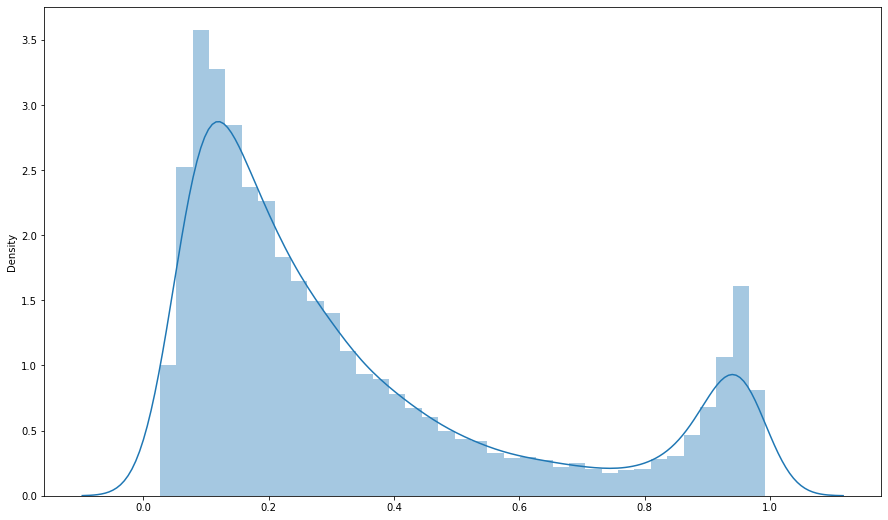

In [61]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

<AxesSubplot:ylabel='Density'>

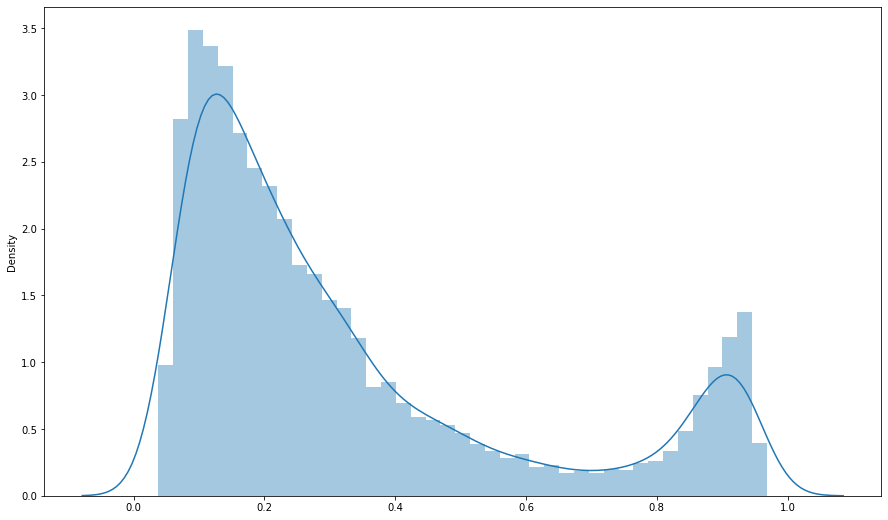

In [121]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

In [63]:
sample_sub = pd.read_csv(data_path+'/sample_submission.csv')
sample_sub = sample_sub.drop('problem', axis=1)

In [64]:
pred_y = pd.DataFrame({'user_id':test_data['user_id'], 'problem':pred_ensemble[:,0]})

In [65]:
sample_sub = pd.merge(sample_sub, pred_y, on='user_id', how='left')
sample_sub['problem'] = sample_sub['problem'].fillna(0)

In [66]:
sample_sub.to_csv("result_new15.csv", index = False)

In [81]:
sample_sub

,user_id,problem
0,30000,0.948919
1,30001,0.250333
2,30002,0.495005
3,30003,0.834989
4,30004,0.939052
...,...,...
14994,44994,0.297094
14995,44995,0.240567
14996,44996,0.637944
14997,44997,0.823894


In [217]:
sample_sub

,user_id,problem
0,30000,0.854289
1,30001,0.266415
2,30002,0.298109
3,30003,0.734431
4,30004,0.863827
...,...,...
14994,44994,0.263009
14995,44995,0.299339
14996,44996,0.437528
14997,44997,0.846632


<AxesSubplot:ylabel='Density'>

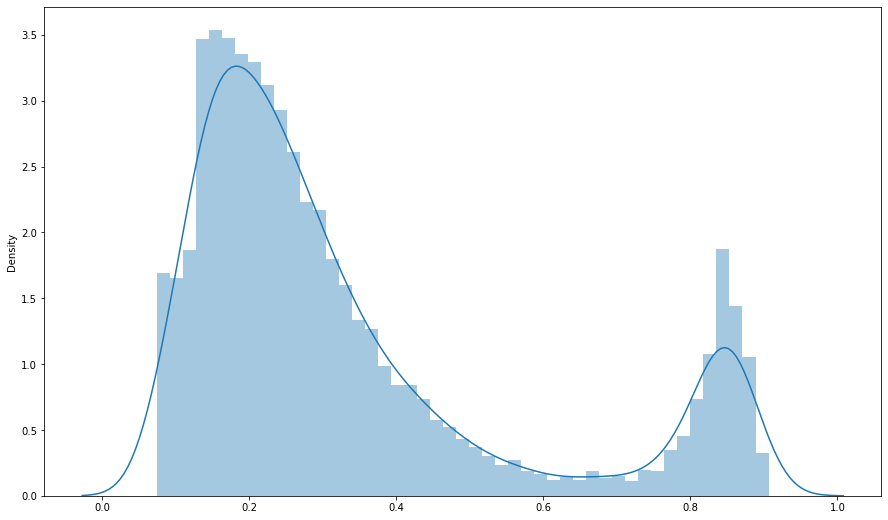

In [218]:
plt.figure(figsize=(15,9))
sns.distplot(pred_ensemble)

,fwver
0,04.33.1185
379,04.33.1261


In [26]:
a['fwver'].tolist()

['04.33.1185', '04.33.1261']

In [27]:
a = [1,2,3]

In [28]:
a[:1] + [5] + a[1:]

[1, 5, 2, 3]